In [ ]:
from google.colab import files
uploaded = files.upload()


Saving AI_Dataset.csv to AI_Dataset.csv


In [ ]:
import pandas as pd

# Load the dataset (uploaded is assumed to be a dict of uploaded files)
df = pd.read_csv(next(iter(uploaded)))

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Select only required columns
df = df[['Course credit',
         'how many hours did you study each week for this subject?',
         'Attendance Rate (%) (Number)',
         'Assignment Score out of 30',
         'Final Exam Results']]

# Rename columns to shorter names
df.rename(columns={
    'Course credit': 'Credit',
    'how many hours did you study each week for this subject?': 'Weekly Study Hours',
    'Attendance Rate (%) (Number)': 'Attendance',
    'Assignment Score out of 30': 'Assignment Score',
    'Final Exam Results': 'Exam Grades'
}, inplace=True)

# Preview the cleaned and renamed columns
print("Cleaned & Renamed Column Names:\n", df.columns.tolist())

# Preview first 5 rows
print(df.head())


Cleaned & Renamed Column Names:
 ['Credit', 'Weekly Study Hours', 'Attendance', 'Assignment Score', 'Exam Grades']
   Credit  Weekly Study Hours Attendance  Assignment Score Exam Grades
0       2                   4    80 - 89                24          B+
1       3                   6    70 - 79                26          B+
2       2                  10    70 - 79                28           A
3       2                   6    90 - 99                12          C+
4       2                   4    90 - 99                22          B+


In [ ]:
print("Missing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Credit                0
Weekly Study Hours    0
Attendance            0
Assignment Score      0
Exam Grades           1
dtype: int64


In [ ]:

def attendance_range_to_avg(value):
    if isinstance(value, str) and '-' in value:
        start, end = value.split('-')
        return (float(start.strip()) + float(end.strip())) / 2
    try:
        return float(value)
    except:
        return None  # or np.nan

# Apply the function to the Attendance column
df['Attendance'] = df['Attendance'].apply(attendance_range_to_avg)

# Check result
print(df['Attendance'].head())


0    84.5
1    74.5
2    74.5
3    94.5
4    94.5
Name: Attendance, dtype: float64


In [ ]:
def simplify_grades(grade):
    grade = str(grade).strip().upper()
    if grade in ['A+', 'A', 'A-']:
        return 'A'
    elif grade in ['B+', 'B', 'B-']:
        return 'B'
    elif grade in ['C+', 'C']:
        return 'C'
    elif grade in ['C-', 'D+', 'D']:
        return 'D'
    else:
        return 'E'

# Apply to your column
df['Exam Grades'] = df['Exam Grades'].apply(simplify_grades)

# Preview result
print(df['Exam Grades'].value_counts())


Exam Grades
B    330
A    321
C    194
D     92
E     65
Name: count, dtype: int64


In [ ]:
# Nicer preview in notebook
df.head(10)


,Credit,Weekly Study Hours,Attendance,Assignment Score,Exam Grades
0,2,4,84.5,24,B
1,3,6,74.5,26,B
2,2,10,74.5,28,A
3,2,6,94.5,12,C
4,2,4,94.5,22,B
5,2,3,100.0,22,B
6,2,4,100.0,22,B
7,3,4,100.0,25,B
8,3,3,100.0,20,C
9,2,4,100.0,17,C


In [ ]:
# Features and label
X = df[['Credit', 'Weekly Study Hours', 'Attendance', 'Assignment Score']]
y = df['Exam Grades']  # use grade labels like A, B, C


In [ ]:
X = X.dropna()
y = y.loc[X.index]  # align y with X


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # A=0, B=1, ...


In [ ]:
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


{'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3), 'E': np.int64(4)}


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

model = Sequential([
    Input(shape=(X.shape[1],)),           # Input layer
    Dense(128, activation='relu'),        # Hidden layer 1
    Dropout(0.1),                          # Dropout layer 1
    Dense(64, activation='relu'),         # Hidden layer 2
    Dropout(0.1),                          # Dropout layer 2
    Dense(32, activation='relu'),         # Hidden layer 3
    Dropout(0.0),                          # Dropout layer 3
    Dense(5, activation='softmax')        # Output layer (for 5 classes)
])


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3601 - loss: 1.4433 - val_accuracy: 0.5839 - val_loss: 0.9437
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6657 - loss: 0.8687 - val_accuracy: 0.7702 - val_loss: 0.6125
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7400 - loss: 0.6152 - val_accuracy: 0.8075 - val_loss: 0.5221
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7514 - loss: 0.5539 - val_accuracy: 0.8012 - val_loss: 0.4858
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7525 - loss: 0.5277 - val_accuracy: 0.7578 - val_loss: 0.4744
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7979 - loss: 0.4917 - val_accuracy: 0.8199 - val_loss: 0.4480
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7972 - loss: 0.4633 - val_accuracy: 0.8075 - val_loss: 0.4360
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7914 - loss: 0.4497 - val_accuracy: 0.8137 - val_loss:

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8272 - loss: 0.6119 
Test Accuracy: 0.8457711338996887


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

y_true = y_test
y_pred_classes = y_pred.argmax(axis=1)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred_classes, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.8458
Precision: 0.8505
Recall: 0.8458
F1 Score: 0.8445


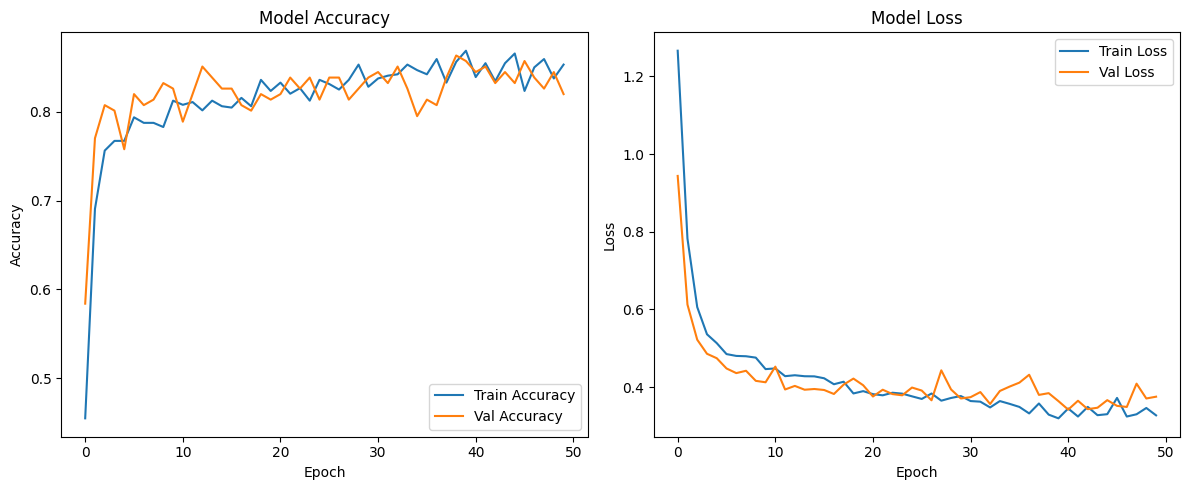

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


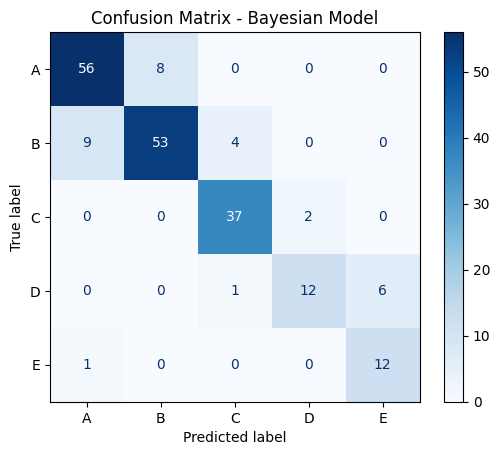

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Map numeric labels to letters (5 classes)
label_mapping = ['A', 'B', 'C', 'D', 'E']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Bayesian Model")
plt.show()


In [23]:
import numpy as np

# Ask user for input values
credit = float(input("Enter course credit (e.g., 2): "))
study_hours = float(input("Enter weekly study hours (e.g., 4): "))
attendance = float(input("Enter attendance percentage (e.g., 60): "))
assignment_score = float(input("Enter assignment score out of 30 (e.g., 10): "))

# Combine into a single input array
manual_input = [[credit, study_hours, attendance, assignment_score]]

# Scale the input using your trained scaler
manual_input_scaled = scaler.transform(manual_input)

# Make prediction
prediction = model.predict(manual_input_scaled)

# Round probabilities
rounded_probs = np.round(prediction[0], 4)

# Get label names from encoder
grade_labels = label_encoder.classes_

# Show probability distribution
prob_dict = dict(zip(grade_labels, rounded_probs))
print("\nPrediction Probabilities (rounded):", prob_dict)

# Get predicted class
predicted_class = np.argmax(prediction)
predicted_grade = label_encoder.inverse_transform([predicted_class])
print("Predicted Grade:", predicted_grade[0])

Enter course credit (e.g., 2): 2
Enter weekly study hours (e.g., 4): 4
Enter attendance percentage (e.g., 60): 85
Enter assignment score out of 30 (e.g., 10): 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Prediction Probabilities (rounded): {'A': np.float32(0.8498), 'B': np.float32(0.1502), 'C': np.float32(0.0), 'D': np.float32(0.0), 'E': np.float32(0.0)}
Predicted Grade: A


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
